In [87]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [88]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [89]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

# Load data

In [91]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [92]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [107]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+1)/(np.percentile(data_all,50,axis=1,keepdims=True)+1)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset L11_2
Sucessfully read dataset L11_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_26936/3830047277.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_26936/3830047277.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset L128_1
Sucessfully read dataset L128_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_26936/3830047277.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_26936/3830047277.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset L128_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_26936/3830047277.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [108]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 41000)].index.tolist()

In [109]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


## Get literature lut

In [110]:
SIMS_masses = adata.var_names

In [111]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [112]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 191


In [113]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

In [114]:
SIMS_masses = SIMS_nm_subset

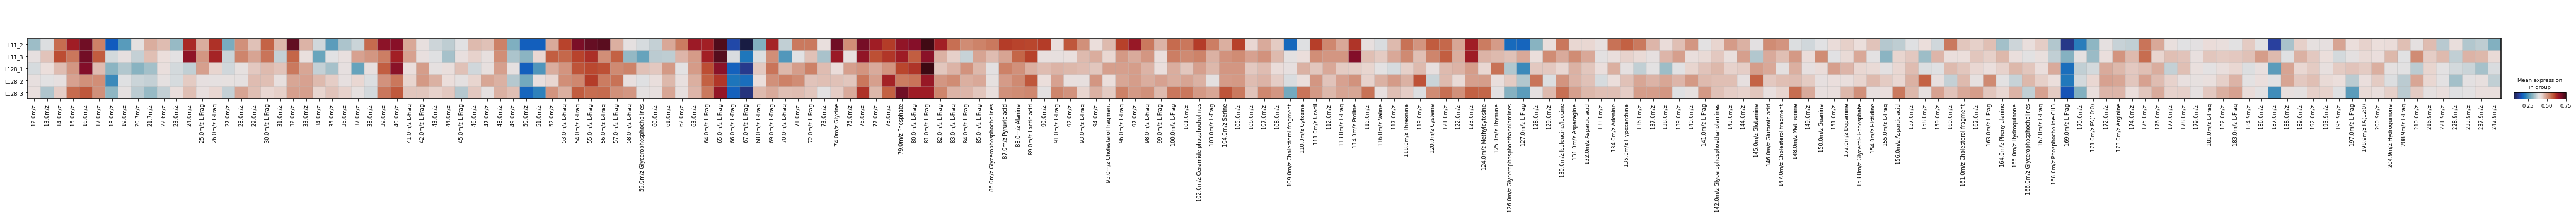

In [115]:

sc.pl.matrixplot(adata, var_names=SIMS_masses, groupby='Dataset', cmap=heatmap_cmp)

# Comparison lean vs obese

In [116]:
adata.obs['Condition'] = adata.obs.Core.map({'L11': 'Obese', 'L128': 'Lean'})
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Condition']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


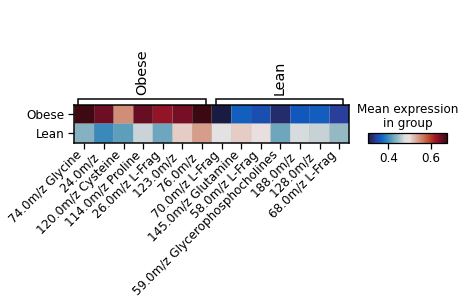

In [117]:
sc.tl.dendrogram(adata, groupby='Condition')
sc.tl.rank_genes_groups(adata, groupby='Condition', method='t-test')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [121]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=20
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [122]:
# Extract dataframe
var = 'Condition'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

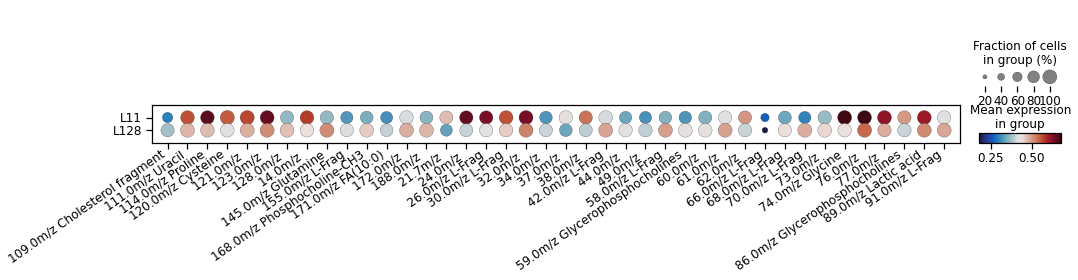

In [123]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.dotplot(adata, var_names=masses, groupby='Core',
                    cmap=heatmap_cmp, dendrogram=True, show=False, expression_cutoff=0.2)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


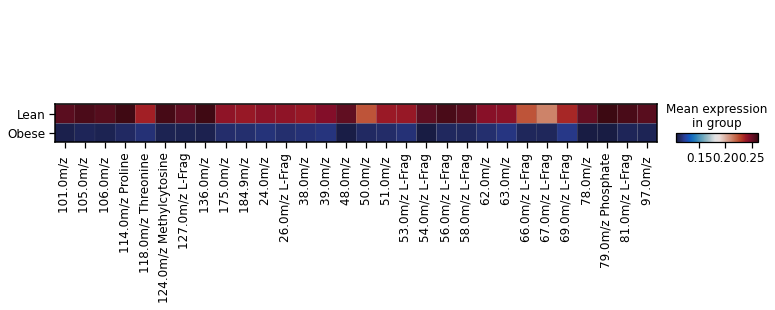

In [56]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs['Type'] = df_SIMS_grouped.index.tolist()
adata_grouped.obs['Type'] = adata_grouped.obs['Type'].astype('category')

sc.tl.dendrogram(adata_grouped, groupby='Type')
with sns.plotting_context('notebook', font_scale=1.2):
    sc.pl.matrixplot(adata_grouped, 
                     var_names=adata_grouped.var_names, 
                     groupby='Type',
                     cmap=heatmap_cmp,
                     dendrogram=True,
                    )

In [50]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'Obese'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

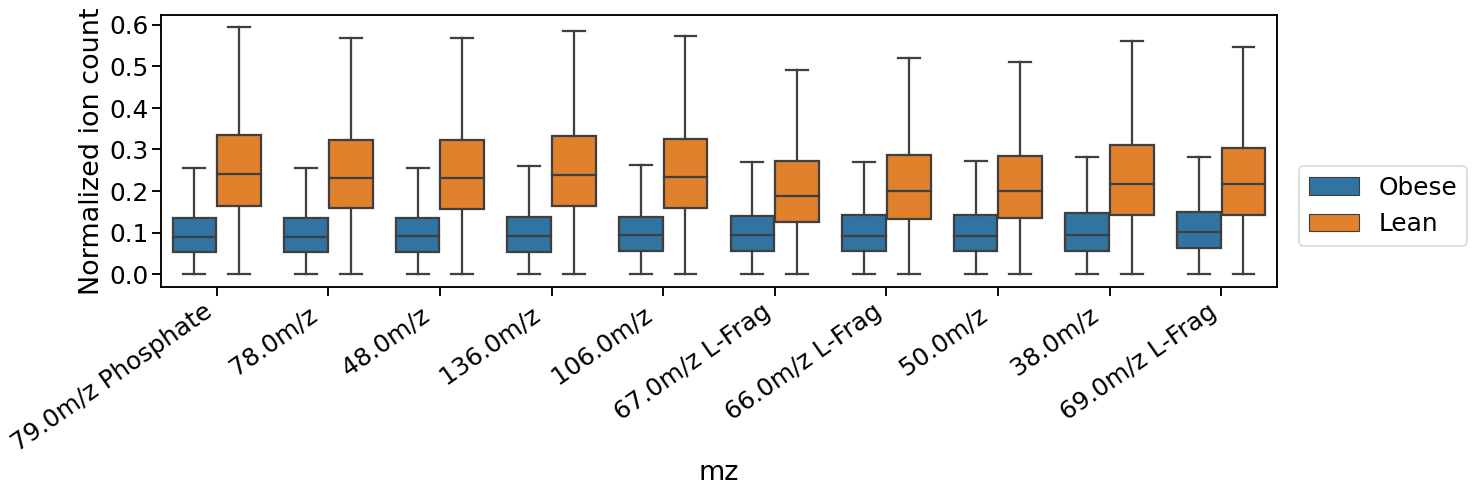

In [51]:
with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20,5))
    sns.boxplot(data=df_SIMS_var, 
                hue=var, 
                x='mz', 
                y='Normalized ion count',
                order=masses_sorted,
                ax=ax, 
                palette='tab10', 
                showfliers=False)
    plt.xticks(rotation = 35, ha='right')
    plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)
